# Teaser

This notebook creates a teaser figure for the documentation and paper.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import lensed_umap as lu

from umap import UMAP
import matplotlib.pyplot as plt
from matplotlib import colors as cl
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.patches import Arc, Ellipse
from matplotlib.collections import PatchCollection, LineCollection

from _plotting import *
configure_matplotlib()
blues = highpassColors()

## Data

The data contains 2D positions and 1 lens dimension.

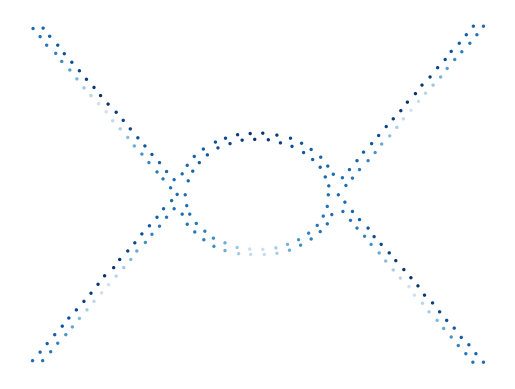

In [3]:
df = pd.read_csv("./data/five_circles.csv", header=0)
lens = np.log(df.hue)

plt.scatter(df.x, df.y, 2, lens, cmap=blues)
plt.axis("off")
plt.show()

## Lenses
Compute the lens-types and store additional info for the figures. 

In [4]:
# Construct UMAP graph
projector = UMAP(repulsion_strength=0.1, negative_sample_rate=2).fit(
    df[["x", "y"]]
)
masker = UMAP(n_neighbors=150, transform_mode="graph").fit(
    df.hue.to_numpy()[None].T
)
regular_lensed, regular_bins = lu.apply_lens(
    projector, lens, discretization="regular", resolution=6, ret_bins=True
)
global_masked = lu.apply_mask(projector, masker)
local_masked = lu.apply_local_mask(projector, lens, n_neighbors=6)

## Helpers

Functions that draw common elements.

In [5]:
arc_width = 0.1
local_arc_width = 0.3
keep_arc_color = "#6E3C08"
remove_arc_color = "silver"
keep_arc_alpha = 0.3
remove_arc_alpha = 0.05
local_keep_arc_alpha = 1
local_remove_arc_alpha = 0.3

node_size = 4
node_cmap = "Blues"
edge_width = 0.3
edge_alpha = 0.2
edge_color = "#6E3C08"

boundary_linetype = ":"
boundary_colour = "k"
boundary_width = 0.5

In [30]:
def draw_nodes(projector, lens, size=None):
    if size is None:
        size = node_size
    x, y = lu.extract_embedding(projector)
    (ix, ax) = x.min(), x.max()
    (iy, ay) = y.min(), y.max()
    plt.scatter(
        (x - ix) / (ax - ix), 
        (y - iy) / (ay - iy), 
        size,
        lens,
        cmap=node_cmap,
        vmin=lens.min(),
        vmax=lens.max(),
        marker=".",
        edgecolors="none",
        linewidths=0,
    )


def draw_edges(projector):
    x, y = lu.extract_embedding(projector)
    (ix, ax) = x.min(), x.max()
    (iy, ay) = y.min(), y.max()
    x = (x - ix) / (ax - ix)
    y = (y - iy) / (ay - iy)
    edges = projector.graph_.tocoo()
    parents = edges.row.astype("int")
    children = edges.col.astype("int")
    lc = LineCollection(
        list(zip(zip(x[children], y[children]), zip(x[parents], y[parents]))),
        linewidth=edge_width,
        color=edge_color,
        alpha=edge_alpha,
        zorder=-1,
    )
    plt.gca().add_collection(lc)


def draw_lens(lens, alpha=1):
    plt.scatter(
        lens,
        np.zeros(len(lens)),
        40,
        lens,
        marker="|",
        cmap=node_cmap,
        vmin=lens.min(),
        vmax=lens.max(),
        alpha=alpha,
    )


def draw_boundaries(bins):
    resolution = len(np.unique(bins))
    lower_boundaries = [np.min(lens[bins == b]) for b in range(resolution)]
    upper_boundaries = [np.max(lens[bins == b]) for b in range(resolution)]
    boundaries = [
        (l + u) / 2 for l, u in zip(lower_boundaries[1:], upper_boundaries[:-1])
    ]

    ylim = plt.ylim()
    for b in boundaries:
        plt.plot(
            [b, b],
            ylim,
            boundary_linetype,
            color=boundary_colour,
            linewidth=boundary_width,
        )
    plt.ylim(ylim)


def draw_lens_arcs(projector, bins):
    base = []
    remove = []
    for row in range(len(lens)):
        start_idx = projector.graph_.indptr[row]
        end_idx = projector.graph_.indptr[row + 1]
        for col in projector.graph_.indices[start_idx:end_idx]:
            radius = abs(lens[row] - lens[col]) / 2
            center = (lens[row] + lens[col]) / 2
            if abs(bins[row] - bins[col]) > 1:
                color = remove_arc_color
                alpha = remove_arc_alpha
                collect = remove
            else:
                color = keep_arc_color
                alpha = keep_arc_alpha
                collect = base

            collect.append(
                Arc(
                    [center, 0.07],
                    2 * radius,
                    1 * radius,
                    theta2=180.0,
                    alpha=alpha,
                    color=color,
                    linewidth=arc_width,
                )
            )
    plt.gca().add_collection(PatchCollection(remove, match_original=True))
    plt.gca().add_collection(PatchCollection(base, match_original=True))


def draw_mask_arcs(projector, masker, lens):
    projector_keep = []
    projector_remove = []
    masker_keep = []
    masker_remove = []

    def _add_projector_remove(row, col):
        radius = abs(lens[row] - lens[col]) / 2
        center = (lens[row] + lens[col]) / 2
        projector_remove.append(
            Arc(
                [center, 0.07],
                2 * radius,
                1 * radius,
                theta2=180.0,
                alpha=remove_arc_alpha,
                color=remove_arc_color,
                linewidth=arc_width,
            )
        )

    def _add_projector_keep(row, col):
        radius = abs(lens[row] - lens[col]) / 2
        center = (lens[row] + lens[col]) / 2
        projector_keep.append(
            Arc(
                [center, 0.07],
                2 * radius,
                1 * radius,
                theta2=180.0,
                alpha=keep_arc_alpha,
                color=keep_arc_color,
                linewidth=arc_width,
            )
        )

    def _add_masker_keep(row, col):
        radius = abs(lens[row] - lens[col]) / 2
        center = (lens[row] + lens[col]) / 2
        masker_keep.append(
            Arc(
                [center, -0.07],
                2 * radius,
                1 * radius,
                theta1=180.0,
                alpha=keep_arc_alpha,
                color=keep_arc_color,
                linewidth=arc_width,
            )
        )

    def _add_masker_remove(row, col):
        radius = abs(lens[row] - lens[col]) / 2
        center = (lens[row] + lens[col]) / 2
        masker_remove.append(
            Arc(
                [center, -0.07],
                2 * radius,
                1 * radius,
                theta1=180.0,
                alpha=remove_arc_alpha,
                color=remove_arc_color,
                linewidth=arc_width,
            )
        )

    # Loop over edges
    for row in range(len(lens)):
        start_idx1 = projector.graph_.indptr[row]
        end_idx1 = projector.graph_.indptr[row + 1]

        start_idx2 = masker.graph_.indptr[row]
        end_idx2 = masker.graph_.indptr[row + 1]

        # Process edges
        while start_idx1 < end_idx1 and start_idx2 < end_idx2:
            col1 = projector.graph_.indices[start_idx1]
            col2 = masker.graph_.indices[start_idx2]
            if col1 == col2:
                _add_projector_keep(row, col1)
                _add_masker_keep(row, col2)
                start_idx1 += 1
                start_idx2 += 1
            elif col1 < col2:
                _add_projector_remove(row, col1)
                start_idx1 += 1
            else:
                _add_masker_remove(row, col2)
                start_idx2 += 1

        # Draw potentially remaining projector edges
        while start_idx1 < end_idx1:
            col = projector.graph_.indices[start_idx1]
            _add_projector_remove(row, col)
            start_idx1 += 1

        # Draw potentially remaining masker edges
        while start_idx2 < end_idx2:
            col = masker.graph_.indices[start_idx2]
            _add_masker_remove(row, col)
            start_idx2 += 1

    plt.gca().add_collection(PatchCollection(projector_remove, match_original=True))
    plt.gca().add_collection(PatchCollection(masker_remove, match_original=True))
    plt.gca().add_collection(PatchCollection(projector_keep, match_original=True))
    plt.gca().add_collection(PatchCollection(masker_keep, match_original=True))


def draw_arcs_for_point(projector, lens, idx, n_neighbors=5):
    start_idx = projector.graph_.indptr[idx]
    end_idx = projector.graph_.indptr[idx + 1]
    columns = projector.graph_.indices[start_idx:end_idx]
    distances = np.abs(lens[idx] - lens[columns])
    columns = columns[np.argsort(distances)]

    plt.text(lens[idx] - 0.03, -0.07, '$\\uparrow$ per point', va='top', ha='left', fontsize=8)
    plt.gca().add_collection(
        PatchCollection(
            [
                Arc(
                    [(lens[idx] + lens[columns[i]]) / 2, 0.07],
                    abs(lens[idx] - lens[columns[i]]),
                    abs(lens[idx] - lens[columns[i]]) / 4.5,
                    theta2=180.0,
                    alpha=local_remove_arc_alpha,
                    color=remove_arc_color,
                    linewidth=local_arc_width,
                )
                for i in range(n_neighbors, len(columns))
            ],
            match_original=True,
        )
    )
    plt.gca().add_collection(
        PatchCollection(
            [
                Arc(
                    [(lens[idx] + lens[columns[i]]) / 2, 0.07],
                    abs(lens[idx] - lens[columns[i]]),
                    abs(lens[idx] - lens[columns[i]]) / 4.5,
                    theta2=180.0,
                    alpha=local_keep_arc_alpha,
                    color=keep_arc_color,
                    linewidth=local_arc_width,
                )
                for i in range(n_neighbors)
            ],
            match_original=True,
        )
    )

## Draw
The code that draws the figure:

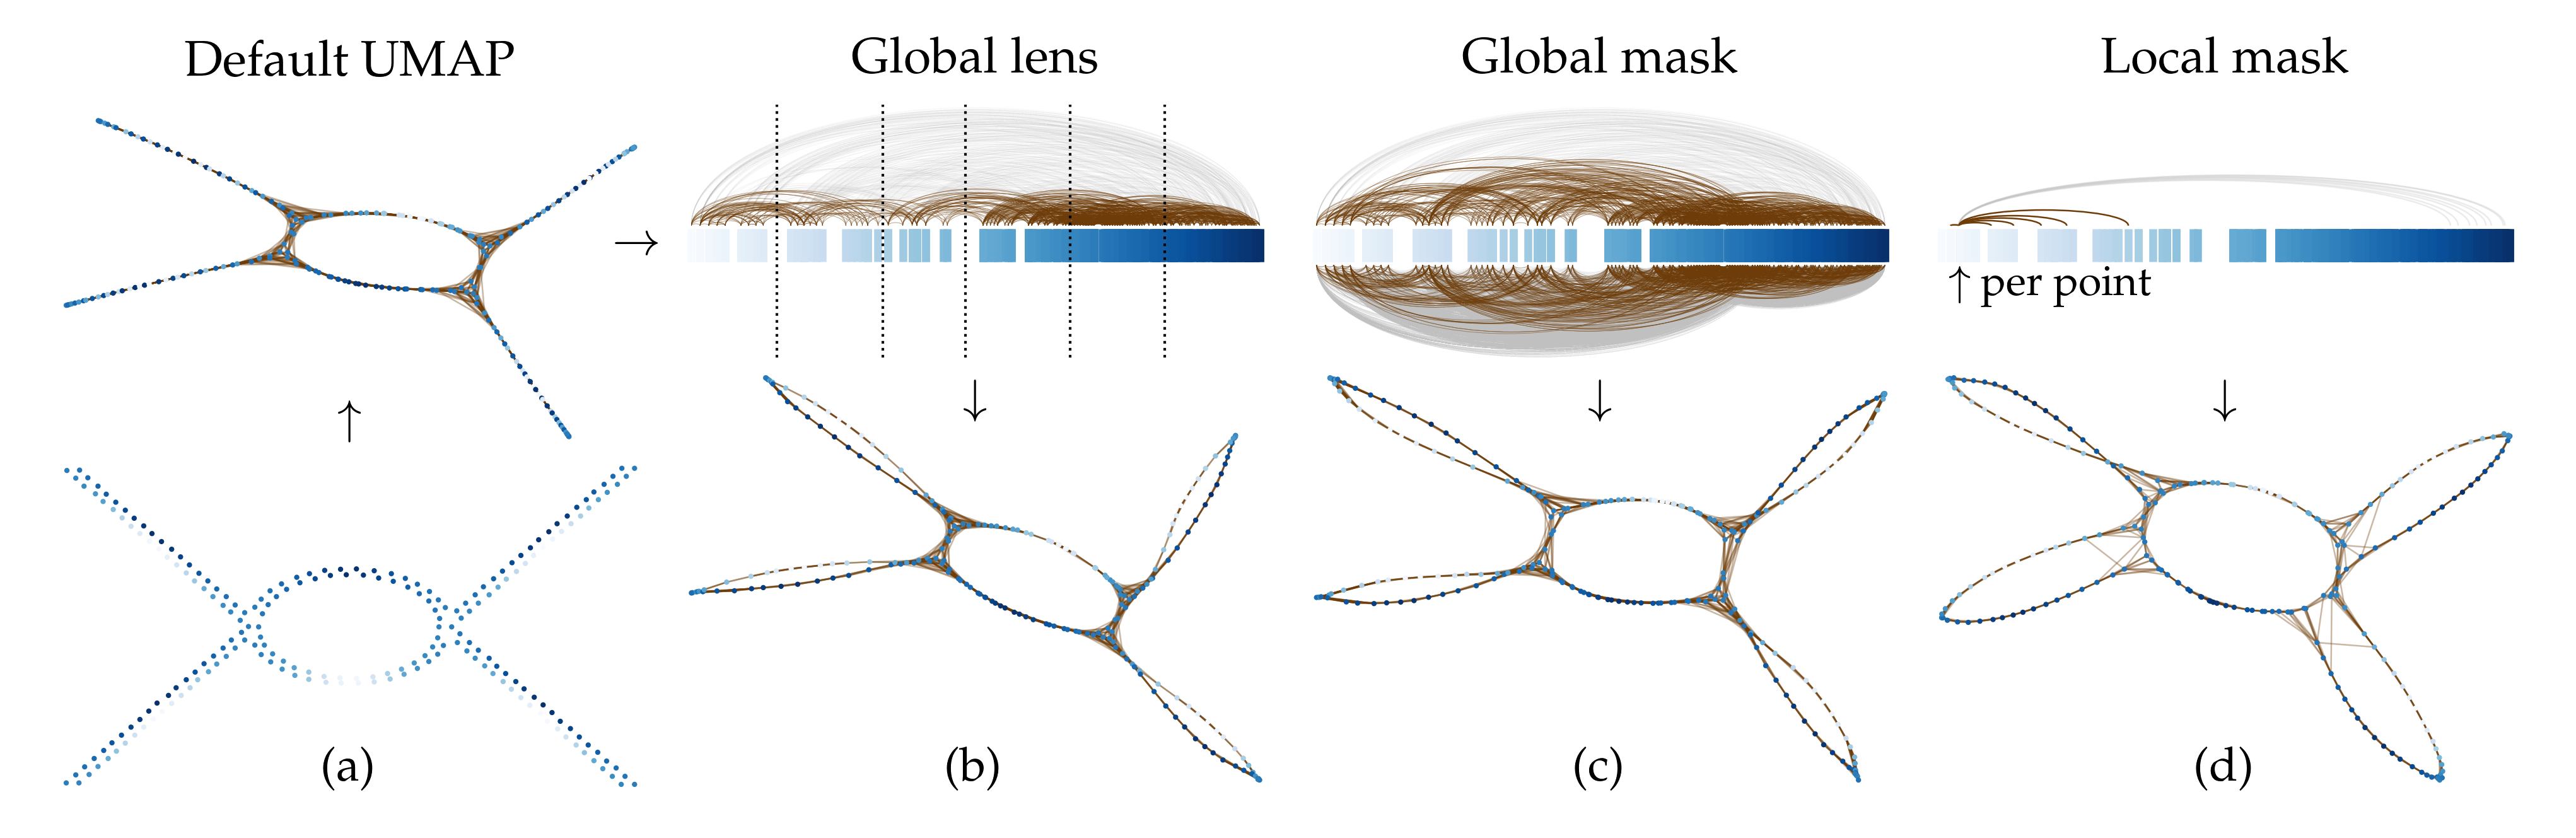

In [31]:
configure_matplotlib()

width = 6.60893 # inch as shown in latex
height = width * 0.618 / 2

fig, axes = plt.subplots(1, 4, figsize=(width, height), dpi=600)
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
gs = []
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.axis('off')
    ratios = [1, 1] if i == 0 else [1, 1.75]
    gs.append(GridSpecFromSubplotSpec(2, 1, ax, height_ratios=ratios))


fig.add_subplot(gs[0][1])
plt.scatter(df.x, df.y, 4, lens, cmap=node_cmap, 
            marker=".", edgecolors="none", linewidths=0)
frame_off()
plt.xlabel('(a)', labelpad=-10)

fig.add_subplot(gs[0][0])
plt.title('Default UMAP', y=0.99)
draw_nodes(projector, lens)
draw_edges(projector)
y_min, y_max = plt.ylim()
x_min, x_max = plt.xlim()
frame_off()
plt.text(1, 0.58, '$\\rightarrow$', fontsize=9, ha='right',
         va='center', transform=plt.gca().transAxes)
plt.xlabel('$\\uparrow$', labelpad=-10)


fig.add_subplot(gs[1][1])
draw_nodes(regular_lensed, lens)
draw_edges(regular_lensed)
frame_off()
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('(b)', labelpad=-10)

fig.add_subplot(gs[1][0])
plt.title('Global lens')
plt.ylim([-0.4, 0.5])
draw_lens(lens)
draw_boundaries(regular_bins)
draw_lens_arcs(projector, regular_bins)
frame_off()
plt.xlabel('$\\downarrow$')


fig.add_subplot(gs[2][1])
draw_nodes(global_masked, lens)
draw_edges(global_masked)
frame_off()
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('(c)', labelpad=-10)

fig.add_subplot(gs[2][0])
plt.title('Global mask')
plt.ylim([-0.4, 0.5])
draw_lens(lens)
draw_mask_arcs(projector, masker, lens)
frame_off()
plt.xlabel('$\\downarrow$')


fig.add_subplot(gs[3][1])
draw_nodes(local_masked, lens)
draw_edges(local_masked)
frame_off()
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.xlabel('(d)', labelpad=-10)

fig.add_subplot(gs[3][0])
plt.title('Local mask')
draw_lens(lens)
plt.ylim([-0.4, 0.5])
draw_arcs_for_point(
    projector,
    lens,
    np.argpartition(lens, 6)[6],
    n_neighbors=6,
)
# draw_arcs_for_point(
#     projector,
#     lens,
#     np.argpartition(lens, len(lens) - 6)[len(lens) - 6],
#     n_neighbors=6,
# )
frame_off()
plt.xlabel('$\\downarrow$')

# Use full figure!
plt.savefig("./figures/teaser.png", dpi=600, pad_inches=0)
plt.savefig("./figures/teaser.pdf", pad_inches=0)
plt.show()